## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import os
import pickle
import copy as cp

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.options.display.max_colwidth = 120

## Directories

In [2]:
HOME_DIR = os.getcwd()
DATA_RAW_DIR = os.path.join(HOME_DIR, 'data_raw')
DATA_INPUT_DIR = os.path.join(HOME_DIR, 'data_input')

## Loading data

Train dataset

In [45]:
train = pd.read_csv(os.path.join(DATA_RAW_DIR,'train.csv'))
train.head()

id  \
0  id26305   
1  id17569   
2  id11008   
3  id27763   
4  id12958   

                                                                                                                      text  \
0  This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circui...   
1                                                  It never once occurred to me that the fumbling might be a mere mistake.   
2  In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic step...   
3  How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by h...   
4  Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally st...   

  author  
0    EAP  
1    HPL  
2    EAP  
3    MWS  
4    HPL

In [47]:
print(train.shape)
train.dtypes

(19579, 3)


id        object
text      object
author    object
dtype: object

Test dataset

In [48]:
test = pd.read_csv(os.path.join(DATA_RAW_DIR,'test.csv'))
test.head()

id  \
0  id02310   
1  id24541   
2  id00134   
3  id27757   
4  id04081   

                                                                                                                      text  
0           Still, as I urged our leaving Ireland with such inquietude and impatience, my father thought it best to yield.  
1  If a fire wanted fanning, it could readily be fanned with a newspaper, and as the government grew weaker, I have no ...  
2  And when they had broken down the frail door they found only this: two cleanly picked human skeletons on the earthen...  
3  While I was thinking how I should possibly manage without them, one actually tumbled out of my head, and, rolling do...  
4                                                                    I am not sure to what limit his knowledge may extend.

In [49]:
print(test.shape)
test.dtypes

(8392, 2)


id      object
text    object
dtype: object

#### Bar chart of class proportion

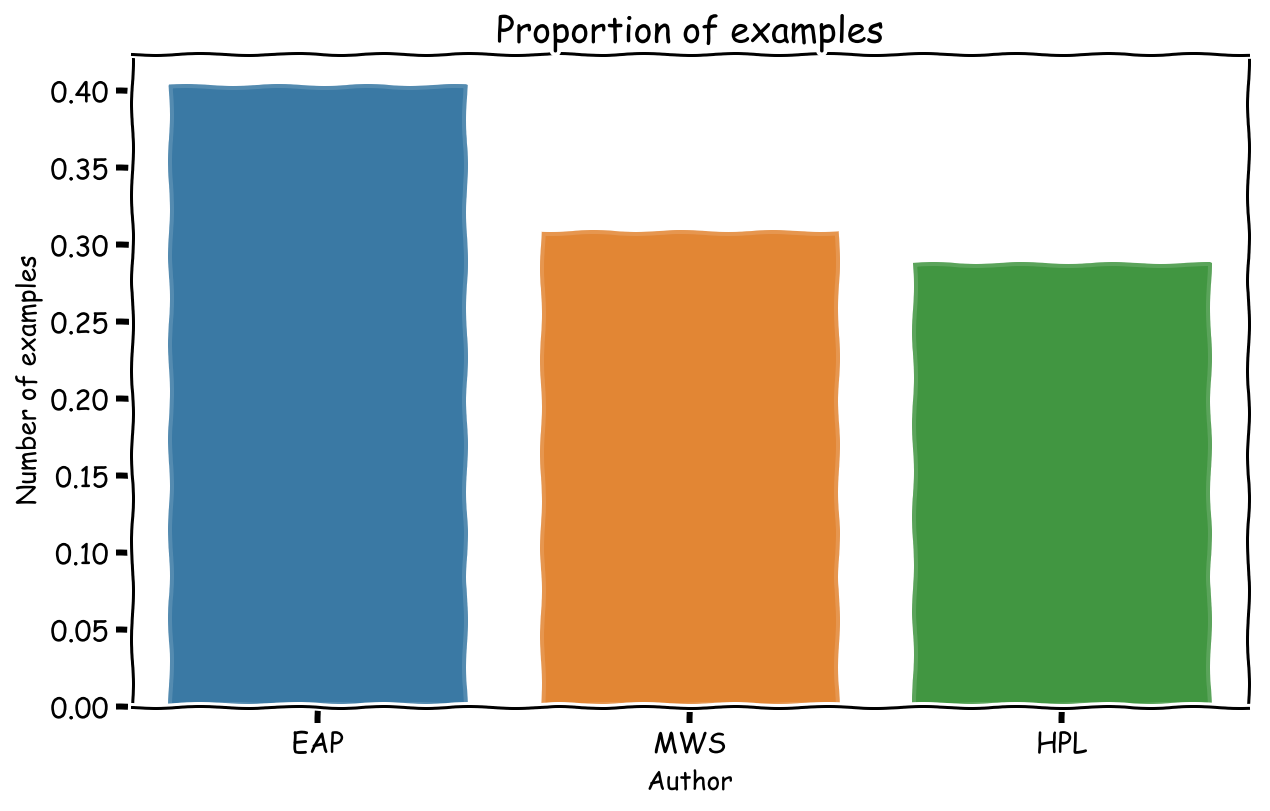

In [50]:
author_count  = train['author'].value_counts()/len(train)
plt.xkcd()
plt.figure(figsize=(10,6))
sns.barplot(author_count.index, author_count.values, alpha=0.8)
plt.ylabel('Number of examples', fontsize=13)
plt.xlabel('Author', fontsize=13)
plt.title('Proportion of examples', fontsize=18)
plt.show()

## Feature Engineering

#### Removing punctions

In [51]:
def remove_punctuation(text):
    '''A function for removing punctuation:
            - replacing the punctuations with no space, which in effect deletes the punctuation marks 
            - return the text stripped of punctuation marks
    '''
    import string
    translator = str.maketrans('','', string.punctuation)
    
    return text.translate(translator)

In [52]:
train.head()

id  \
0  id26305   
1  id17569   
2  id11008   
3  id27763   
4  id12958   

                                                                                                                      text  \
0  This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circui...   
1                                                  It never once occurred to me that the fumbling might be a mere mistake.   
2  In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic step...   
3  How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by h...   
4  Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally st...   

  author  
0    EAP  
1    HPL  
2    EAP  
3    MWS  
4    HPL

In [53]:
train['text'] = train['text'].apply(remove_punctuation)
train.head()

id  \
0  id26305   
1  id17569   
2  id11008   
3  id27763   
4  id12958   

                                                                                                                      text  \
0  This process however afforded me no means of ascertaining the dimensions of my dungeon as I might make its circuit a...   
1                                                   It never once occurred to me that the fumbling might be a mere mistake   
2  In his left hand was a gold snuff box from which as he capered down the hill cutting all manner of fantastic steps h...   
3  How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath speckled by ha...   
4  Finding nothing else not even gold the Superintendent abandoned his attempts but a perplexed look occasionally steal...   

  author  
0    EAP  
1    HPL  
2    EAP  
3    MWS  
4    HPL

#### Removing stopwords

Extracting the stopwords from nltk library

In [54]:
sw = stopwords.words('english')
np.array(sw)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [55]:
print("Number of stopwords: ", len(sw))

Number of stopwords:  179


#### Function to remove stopwords

In [56]:
sw = stopwords.words('english')

In [3]:
def my_stopwords(text):
    '''a function for removing the stopword
            - removing the stop words and lowercasing the selected words
            - joining the list of words with space separator
    '''
    sw = stopwords.words('english')
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    return " ".join(text)

In [58]:
train['text'] = train['text'].apply(my_stopwords)
train.head()

id  \
0  id26305   
1  id17569   
2  id11008   
3  id27763   
4  id12958   

                                                                                                                      text  \
0  process however afforded means ascertaining dimensions dungeon might make circuit return point whence set without aw...   
1                                                                               never occurred fumbling might mere mistake   
2  left hand gold snuff box capered hill cutting manner fantastic steps took snuff incessantly air greatest possible se...   
3  lovely spring looked windsor terrace sixteen fertile counties spread beneath speckled happy cottages wealthier towns...   
4  finding nothing else even gold superintendent abandoned attempts perplexed look occasionally steals countenance sits...   

  author  
0    EAP  
1    HPL  
2    EAP  
3    MWS  
4    HPL

## Top words before stemming

#### Collect vocabulary count

Create a count vectorizer object

In [59]:
count_vectorizer = CountVectorizer()

Fit the count vectorizer using the text data

In [60]:
count_vectorizer.fit(train['text']) 

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Collect the vocabulary items used in the vectorizer

In [61]:
count_vectorizer.vocabulary_

{'process': 17284,
 'however': 10865,
 'afforded': 455,
 'means': 13823,
 'ascertaining': 1301,
 'dimensions': 6188,
 'dungeon': 6957,
 'might': 14060,
 'make': 13510,
 'circuit': 3762,
 'return': 18738,
 'point': 16780,
 'whence': 24685,
 'set': 19861,
 'without': 24918,
 'aware': 1654,
 'fact': 8295,
 'perfectly': 16214,
 'uniform': 23486,
 'seemed': 19713,
 'wall': 24428,
 'never': 14862,
 'occurred': 15251,
 'fumbling': 9339,
 'mere': 13966,
 'mistake': 14207,
 'left': 12862,
 'hand': 10227,
 'gold': 9816,
 'snuff': 20538,
 'box': 2602,
 'capered': 3141,
 'hill': 10639,
 'cutting': 5297,
 'manner': 13591,
 'fantastic': 8401,
 'steps': 21142,
 'took': 22617,
 'incessantly': 11358,
 'air': 555,
 'greatest': 9965,
 'possible': 16935,
 'self': 19743,
 'satisfaction': 19370,
 'lovely': 13298,
 'spring': 20926,
 'looked': 13238,
 'windsor': 24858,
 'terrace': 22194,
 'sixteen': 20306,
 'fertile': 8592,
 'counties': 4928,
 'spread': 20919,
 'beneath': 2114,
 'speckled': 20797,
 'happy': 1

In [62]:
dictionary = count_vectorizer.vocabulary_.items() 

Store the vocab and counts in a pandas dataframe

In [63]:
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_bef_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_bef_stem = vocab_bef_stem.sort_values(ascending=False)

#### Bar plot of top words before stemming

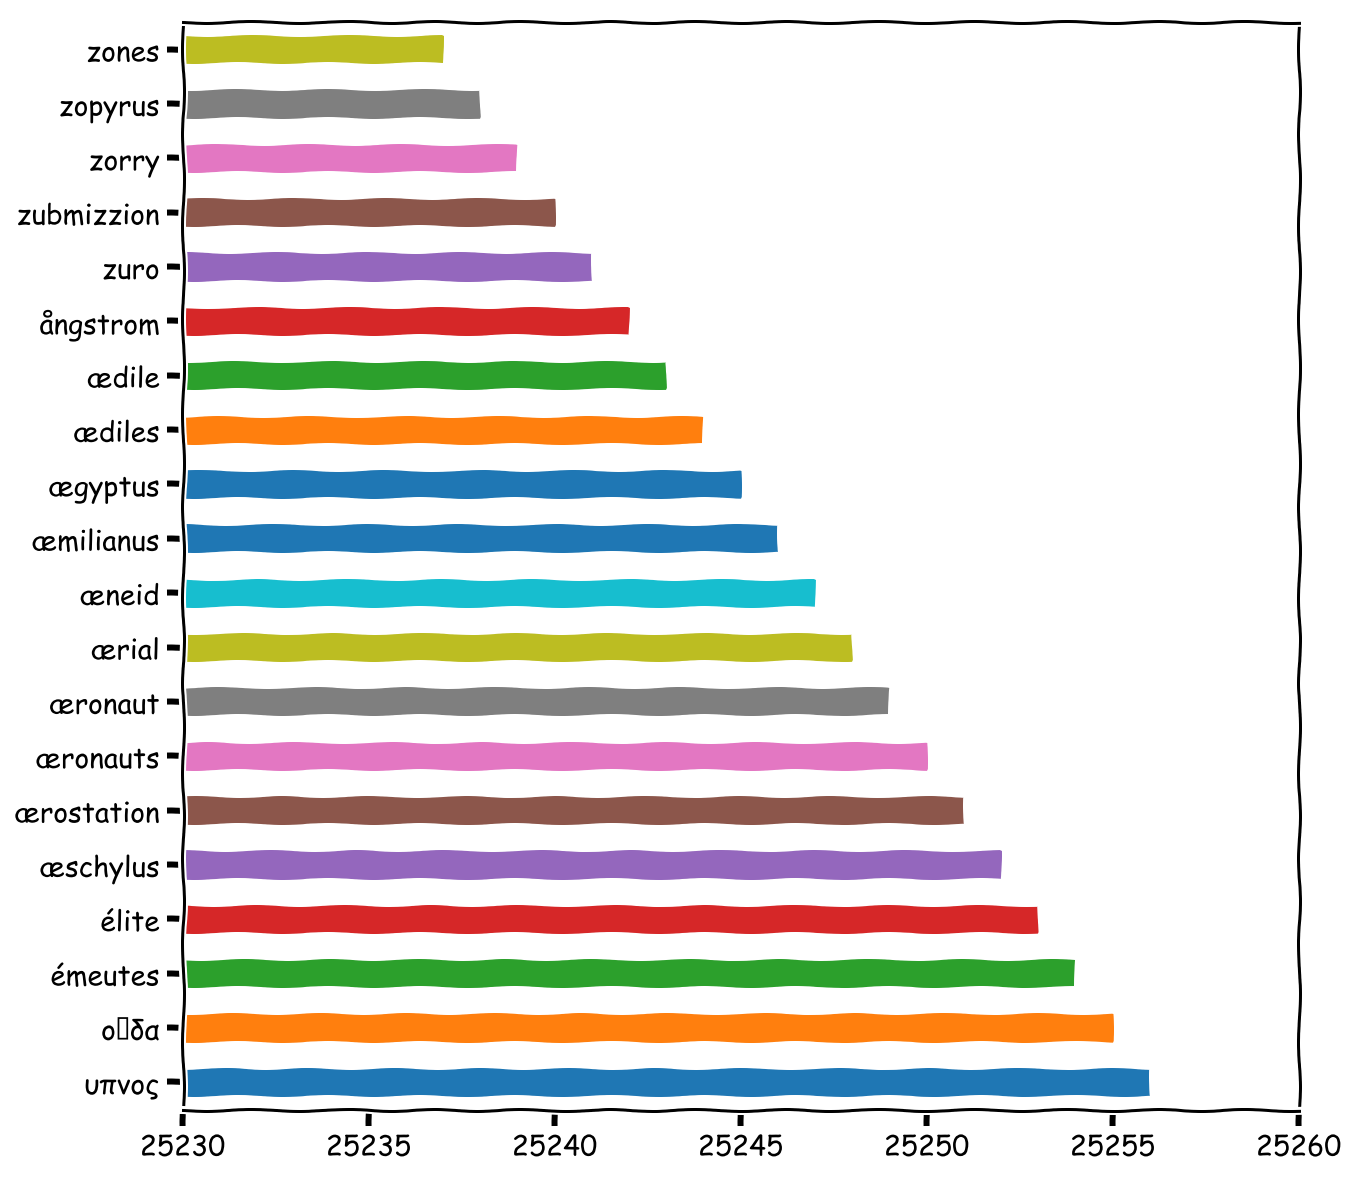

In [64]:
top_vacab = vocab_bef_stem.head(20)
top_vacab.plot(kind = 'barh', figsize=(10,10), xlim= (25230, 25260))

## Stemming operations

Stemming operation bundles together words of same root. E.g. stem operation bundles "response" and "respond" into a common "respon".

#### A funtion to carry out stemming operation

Create an object of stemming function

In [65]:
def stemming(text):    
    '''a function which stems each word in the given text
    '''
    stemmer = SnowballStemmer("english")
    text = [stemmer.stem(word) for word in text.split()]
    
    return " ".join(text) 

Applying it to each example

In [66]:
train.head()

id  \
0  id26305   
1  id17569   
2  id11008   
3  id27763   
4  id12958   

                                                                                                                      text  \
0  process however afforded means ascertaining dimensions dungeon might make circuit return point whence set without aw...   
1                                                                               never occurred fumbling might mere mistake   
2  left hand gold snuff box capered hill cutting manner fantastic steps took snuff incessantly air greatest possible se...   
3  lovely spring looked windsor terrace sixteen fertile counties spread beneath speckled happy cottages wealthier towns...   
4  finding nothing else even gold superintendent abandoned attempts perplexed look occasionally steals countenance sits...   

  author  
0    EAP  
1    HPL  
2    EAP  
3    MWS  
4    HPL

In [67]:
train['text'] = train['text'].apply(stemming)
train.head()

id  \
0  id26305   
1  id17569   
2  id11008   
3  id27763   
4  id12958   

                                                                                                                      text  \
0  process howev afford mean ascertain dimens dungeon might make circuit return point whenc set without awar fact perfe...   
1                                                                                      never occur fumbl might mere mistak   
2        left hand gold snuff box caper hill cut manner fantast step took snuff incess air greatest possibl self satisfact   
3  love spring look windsor terrac sixteen fertil counti spread beneath speckl happi cottag wealthier town look former ...   
4                   find noth els even gold superintend abandon attempt perplex look occasion steal counten sit think desk   

  author  
0    EAP  
1    HPL  
2    EAP  
3    MWS  
4    HPL

## Top words after stemming operation

#### Collect vocabulary count

Create the object of tfid vectorizer

In [68]:
tfid_vectorizer = TfidfVectorizer("english") 

Fit the vectorizer using the text data

In [69]:
tfid_vectorizer.fit(train['text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='english',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

Collect the vocabulary items used in the vectorizer

In [70]:
dictionary = tfid_vectorizer.vocabulary_.items() 

#### Bar plot of top words after stemming

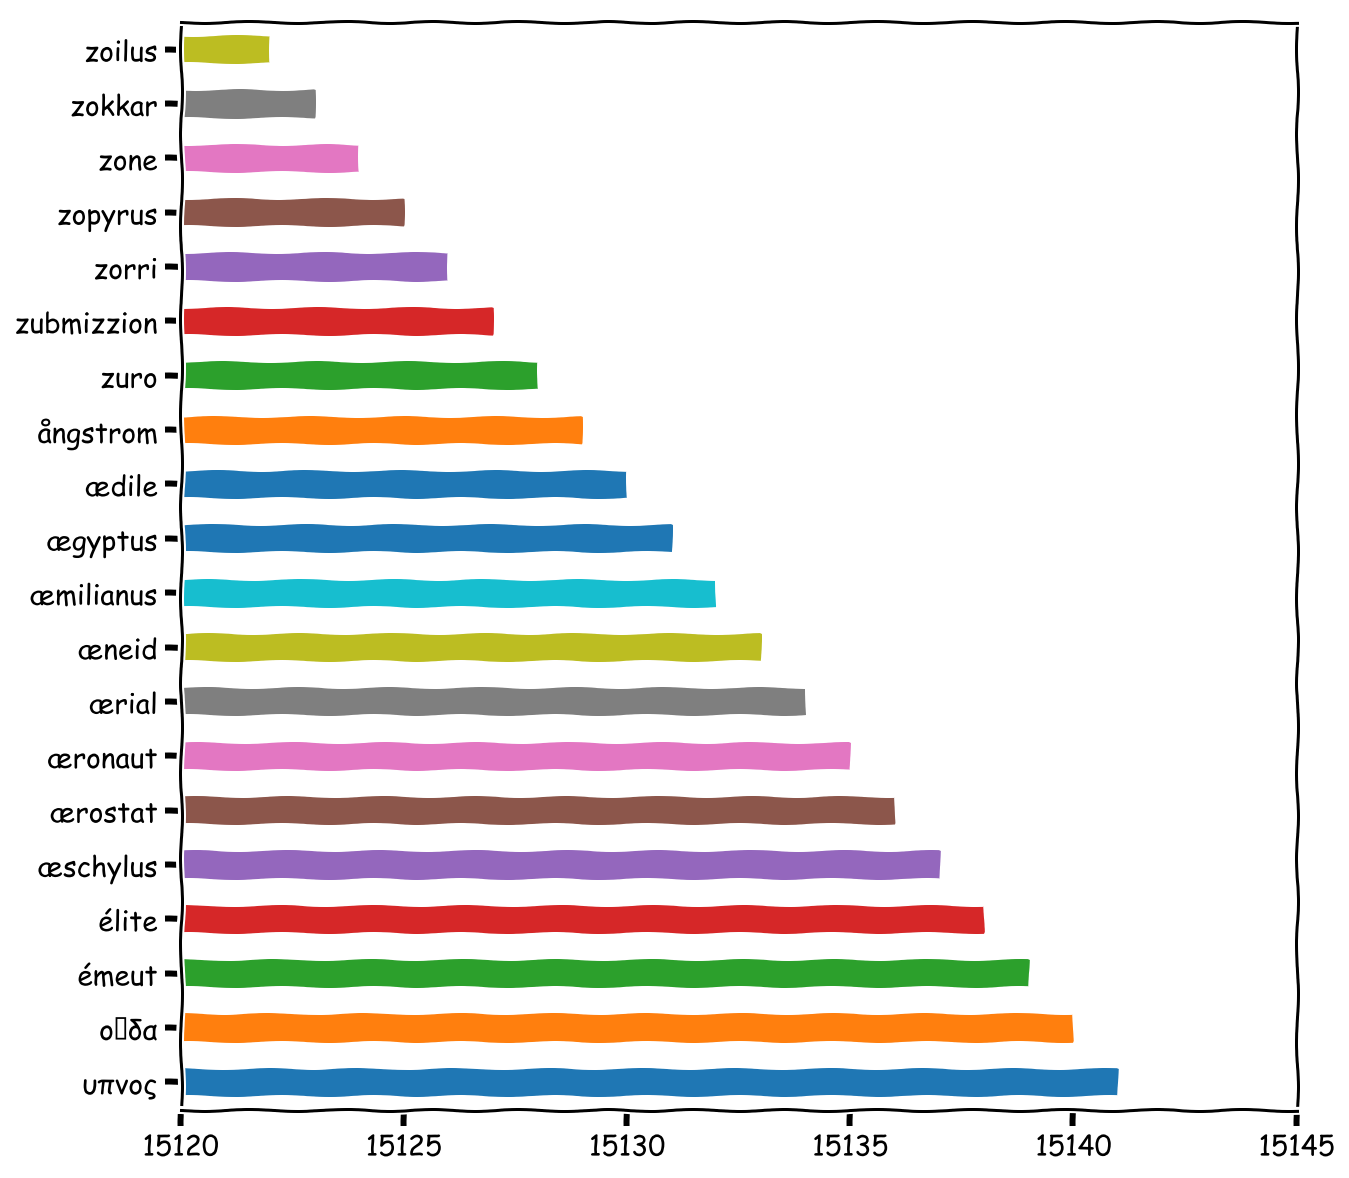

In [71]:
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_after_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_after_stem = vocab_after_stem.sort_values(ascending=False)
# plot of the top vocab
top_vacab = vocab_after_stem.head(20)
top_vacab.plot(kind = 'barh', figsize=(10,10), xlim= (15120, 15145))

## Histogram of text length of each writer

A function to return the length of text

In [72]:
def length(text):    
    '''a function which returns the length of text
    '''
    return len(text)

Adding new column with string lenth

In [73]:
train['length'] = train['text'].apply(length)
train.head()

id  \
0  id26305   
1  id17569   
2  id11008   
3  id27763   
4  id12958   

                                                                                                                      text  \
0  process howev afford mean ascertain dimens dungeon might make circuit return point whenc set without awar fact perfe...   
1                                                                                      never occur fumbl might mere mistak   
2        left hand gold snuff box caper hill cut manner fantast step took snuff incess air greatest possibl self satisfact   
3  love spring look windsor terrac sixteen fertil counti spread beneath speckl happi cottag wealthier town look former ...   
4                   find noth els even gold superintend abandon attempt perplex look occasion steal counten sit think desk   

  author  length  
0    EAP     136  
1    HPL      35  
2    EAP     113  
3    MWS     137  
4    HPL     102

Extracting data of each class

In [74]:
EAP_train = train[train['author'] == 'EAP']
HPL_train = train[train['author'] == 'HPL']
MWS_train = train[train['author'] == 'MWS']

Histogram of text lenght of each writer

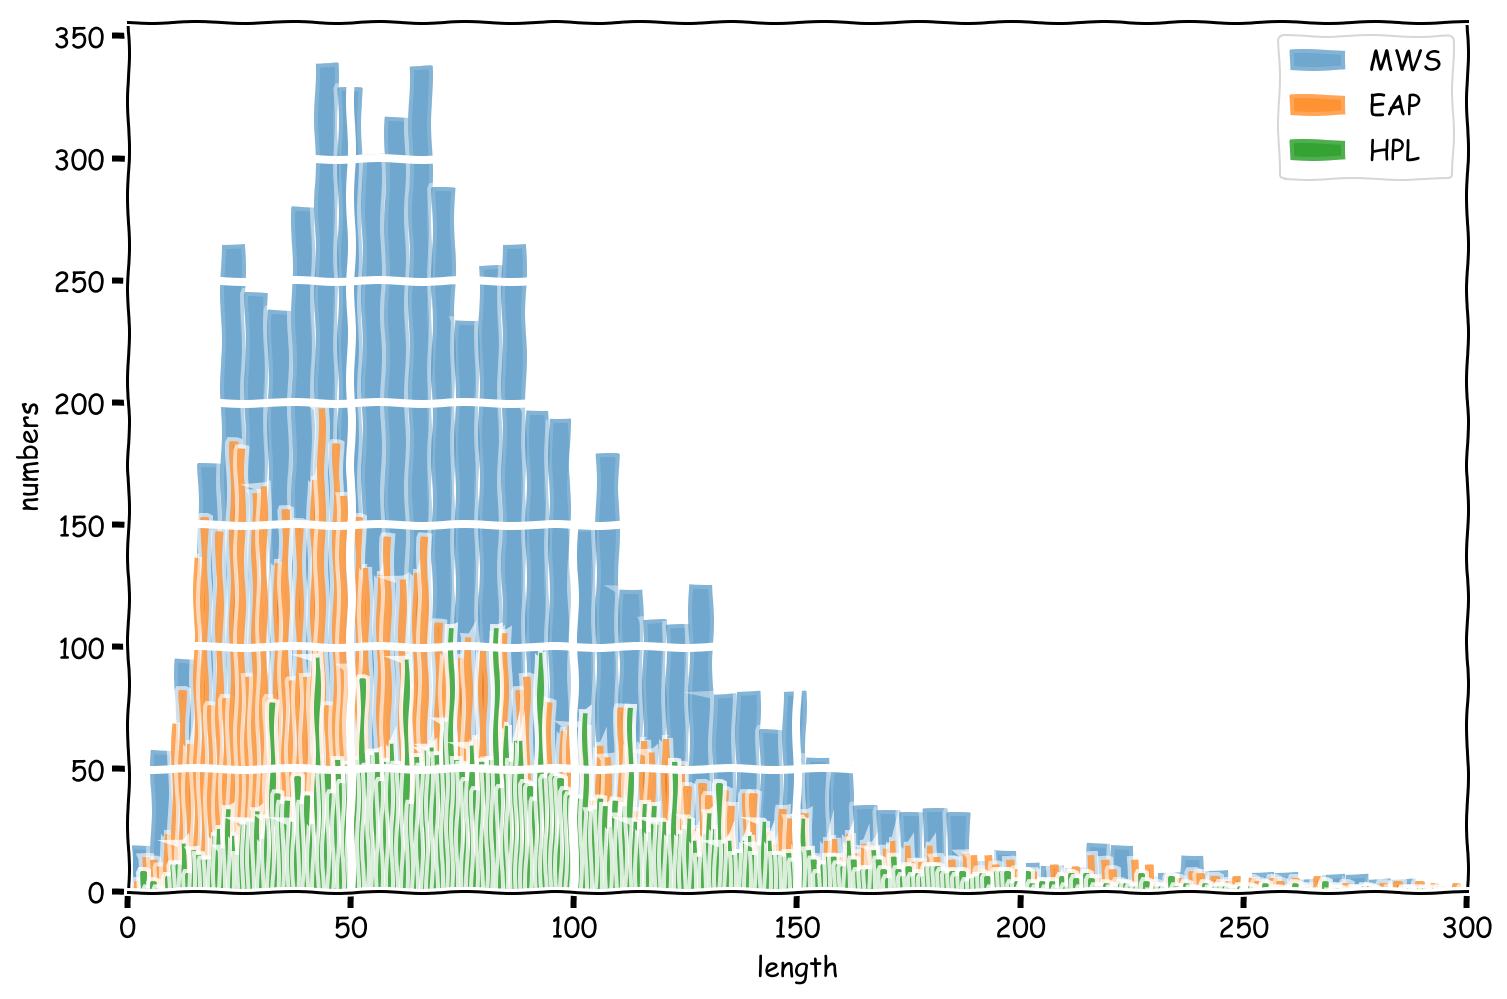

In [75]:
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
bins = 500
plt.hist(MWS_train['length'], alpha = 0.4, bins=bins, label='MWS')
plt.hist(EAP_train['length'], alpha = 0.6, bins=bins, label='EAP')
plt.hist(HPL_train['length'], alpha = 0.8, bins=bins, label='HPL')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,300)
plt.grid()
plt.show()

## TF-IDF Extraction

tf-idf weight is product of two terms: the first term is the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

- TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

- IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

Extract the tfid representation matrix of the text data

In [76]:
tfid_matrix = tfid_vectorizer.transform(train['text'])

Collect the tfid matrix in numpy array

In [77]:
array = tfid_matrix.todense()

In [78]:
df = pd.DataFrame(array)
df.head(10)

0      1      2      3         4      5      6      7      8      9      \
0    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0    0.0   
1    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0    0.0   
2    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0    0.0   
3    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0    0.0   
4    0.0    0.0    0.0    0.0  0.266318    0.0    0.0    0.0    0.0    0.0   
5    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0    0.0   
6    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0    0.0   
7    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0    0.0   
8    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0    0.0   
9    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0    0.0   

   ...    15132  15133  15134  15135  15136  15137  15138  15139  15140  15141  
0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
5  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
6  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
7  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
8  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
9  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[10 rows x 15142 columns]

In [79]:
df.shape

(19579, 15142)

## Training Model

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
train = pd.read_csv(os.path.join(DATA_RAW_DIR,'train.csv'))
test = pd.read_csv(os.path.join(DATA_RAW_DIR,'test.csv'))

In [13]:
X_train = train.text
y_train = train.author.values
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [14]:
X_test = test.text

In [8]:
def preprocess_text(text_column):
    
    text_column = text_column.apply(remove_punctuation)
    
    text_column = text_column.apply(my_stopwords)
    
    text_column = text_column.apply(stemming)
    
    return text_column

In [104]:
X_train = preprocess_text(X_train)
X_valid = preprocess_text(X_valid)
X_test = preprocess_text(X_test)

In [105]:
tfid_vectorizer = TfidfVectorizer("english") 

In [106]:
tfid_vectorizer.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='english',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [107]:
x_train_tfidf = pd.DataFrame(tfid_vectorizer.transform(X_train).todense())
x_valid_tfidf = pd.DataFrame(tfid_vectorizer.transform(X_valid).todense())
x_test_tfidf = pd.DataFrame(tfid_vectorizer.transform(X_test).todense())

### Serialized

In [108]:
with open(os.path.join(DATA_INPUT_DIR,'x_train_tfidf.pkl'), 'wb') as fh:
    pickle.dump(x_train_tfidf, fh)

In [109]:
with open(os.path.join(DATA_INPUT_DIR,'x_test_tfidf.pkl'), 'wb') as fh:
    pickle.dump(x_test_tfidf, fh)

In [110]:
with open(os.path.join(DATA_INPUT_DIR,'x_valid_tfidf.pkl'), 'wb') as fh:
    pickle.dump(x_valid_tfidf, fh)

## Deserialized

In [3]:
with open(os.path.join(DATA_INPUT_DIR,'x_train_tfidf.pkl'), 'rb') as fh:
    x_train_tfidf = pickle.load(fh)

In [4]:
with open(os.path.join(DATA_INPUT_DIR,'x_test_tfidf.pkl'), 'rb') as fh:
    x_test_tfidf = pickle.load(fh)

In [5]:
with open(os.path.join(DATA_INPUT_DIR,'x_valid_tfidf.pkl'), 'rb') as fh:
    x_valid_tfidf = pickle.load(fh)

In [6]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time
import scipy.stats as st
from contextlib import contextmanager

In [7]:
@contextmanager
def elapsed_time(func_name=''):
    """
    Function calculates time of computation.
    """
    start_time = time.time()
    yield
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(f'{func_name} took: {elapsed_time}')

## MultinomialNB

In [216]:
MNB_params = {"alpha" : np.linspace(0.001, 0.2, 20)}

In [217]:
model_multNB = GridSearchCV(MultinomialNB(), MNB_params, scoring = 'neg_log_loss', 
                            cv = 4).fit(x_train_tfidf, y_train)

In [218]:
model_multNB.best_params_

{'alpha': 0.021947368421052632}

In [219]:
MNB = MultinomialNB(alpha=0.022).fit(x_train_tfidf ,y_train)

In [220]:
with open(os.path.join(DATA_INPUT_DIR,'MNB_model.pkl'),'wb') as fh:
    pickle.dump(MNB, fh)

In [8]:
with open(os.path.join(DATA_INPUT_DIR,'MNB_model.pkl'),'rb') as fh:
    MNB = pickle.load(fh)

In [9]:
pred_MNB_train = MNB.predict(x_train_tfidf)
pred_MNB_valid = MNB.predict(x_valid_tfidf)

In [15]:
accuracy_score(y_train, pred_MNB_train)

0.9306007789057014

In [16]:
accuracy_score(y_valid, pred_MNB_valid)

0.8212461695607763

## Gaussian NB

In [225]:
GNB = GaussianNB().fit(x_train_tfidf, y_train)

In [226]:
with open(os.path.join(DATA_INPUT_DIR,'GNB_model.pkl'),'wb') as fh:
    pickle.dump(GNB, fh)

In [17]:
with open(os.path.join(DATA_INPUT_DIR,'GNB_model.pkl'),'rb') as fh:
    GNB = pickle.load(fh)

In [18]:
pred_GNB_train = GNB.predict(x_train_tfidf)
pred_GNB_valid = GNB.predict(x_valid_tfidf)

In [19]:
accuracy_score(y_train, pred_GNB_train)

0.8057204877737343

In [20]:
accuracy_score(y_valid, pred_GNB_valid)

0.6583248212461695

## Bernoulli NB

In [231]:
BNB_params = {'alpha' : np.linspace(0.01, 0.2, 20)}

In [232]:
model_BNB = GridSearchCV(BernoulliNB(), BNB_params, scoring = 'neg_log_loss', 
                            cv = 4).fit(x_train_tfidf, y_train)

In [233]:
model_BNB.best_params_

{'alpha': 0.2}

In [234]:
BNB = BernoulliNB(alpha=0.05).fit(x_train_tfidf, y_train)

In [235]:
with open(os.path.join(DATA_INPUT_DIR,'BNB_model.pkl'),'wb') as fh:
    pickle.dump(BNB, fh)

In [21]:
with open(os.path.join(DATA_INPUT_DIR,'BNB_model.pkl'),'rb') as fh:
    BNB = pickle.load(fh)

In [22]:
pred_BNB_train = BNB.predict(x_train_tfidf)
pred_BNB_valid = BNB.predict(x_valid_tfidf)

In [23]:
accuracy_score(y_train, pred_BNB_train)

0.917001851497159

In [24]:
accuracy_score(y_valid, pred_BNB_valid)

0.8332482124616956

## Decision Tree

In [29]:
params_dt = {'max_depth' : st.randint(4,10),
            'min_samples_split' : st.randint(25,100),
            'min_samples_leaf': st.randint(5,50)
            }

In [30]:
with elapsed_time('Optimization of Decision Tree hyperparameters'):
    DT_search = RandomizedSearchCV(estimator=DecisionTreeClassifier(), param_distributions=params_dt, 
                   scoring='neg_log_loss', refit=True, cv=3, n_iter=30, verbose=3, n_jobs=2).fit(x_train_tfidf, y_train)

Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  7.0min finished


Optimization of Decision Tree hyperparameters took: 464.2115511894226


In [31]:
DT_search.best_params_

{'max_depth': 9, 'min_samples_leaf': 39, 'min_samples_split': 96}

In [32]:
DT = DecisionTreeClassifier(**DT_search.best_params_).fit(x_train_tfidf, y_train)

In [33]:
with open(os.path.join(DATA_INPUT_DIR,'DT_model.pkl'),'wb') as fh:
    pickle.dump(DT, fh)

In [34]:
with open(os.path.join(DATA_INPUT_DIR,'DT_model.pkl'),'rb') as fh:
    DT = pickle.load(fh)

In [35]:
pred_DT_train = DT.predict(x_train_tfidf)
pred_DT_valid = DT.predict(x_valid_tfidf)

In [36]:
accuracy_score(y_train, pred_DT_train)

0.4836238268530933

In [37]:
accuracy_score(y_valid, pred_DT_valid)

0.4821246169560776